In [1]:

import os

os.environ[
    "OMP_NUM_THREADS"
] = "16" 

import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

import pickle
from classifiers.r_method import RMethodClassifier
from mpl_toolkits.axes_grid1 import make_axes_locatable  # 新增导入
from utils import merge_datasets
import seaborn as sns

In [2]:
with open('input_0219_0224_0225_0226_0227_contour_th_128.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

input_all = []
for t in range(5):
    index_d = data.loc[data['source'] == 'source_%s'%t].index.values
    input_d = [[pixels[0][index_d], pixels[1][index_d]], data.loc[index_d]]
    input_all.append(input_d)
input_names = ['0219', '0224', '0225', '0226', '0227', 'all']

In [4]:
input_24_26_27 = merge_datasets([input_all[1], input_all[3], input_all[4]])

0
1
2


In [5]:
input_24_26_27[1]

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight,source,Zn_Pb_grade
99,1,13.970,13.350,23.720,0.0,19.3,source_0,37.070
100,2,24.430,3.917,0.319,0.0,25.6,source_0,4.236
102,4,21.380,0.034,0.036,0.0,46.6,source_0,0.070
103,5,16.500,0.175,0.533,0.0,48.3,source_0,0.708
104,6,8.495,14.770,33.310,0.0,65.7,source_0,48.080
...,...,...,...,...,...,...,...,...
1512,101,8.414,0.065,0.037,0.0,47.3,source_2,0.102
1513,102,4.789,0.065,0.022,0.0,46.3,source_2,0.087
1514,103,4.882,7.838,0.509,0.0,34.8,source_2,8.347
1515,104,23.920,22.030,4.930,0.0,29.7,source_2,26.960


In [6]:
R_0219 = RMethodClassifier(pixels=input_24_26_27[0], truth=input_24_26_27[1], I0_low=195, I0_high=196, 
                           input= 'pixels', method= 'a', const= [5, 20], include_Fe = False)
grade_ths = np.arange(0.1, 7, 0.1)
all_tuning = []
for grade_th in grade_ths:
    R_0219.tuning(min_recovery_rate=0.95, min_scrap_rate=0.2, A_range=np.arange(0.5, 1.2, 0.01), step_B=0.02, 
                  grade_real_th= grade_th/100.0, score_on=True, score_weight=True, check_metrics=False)
    all_tuning.append(R_0219.tuning_results)

In [30]:
with open('grades_0p1_7_ths_0p01_0p02.pkl', 'wb') as f:
    pickle.dump(all_tuning, f)

In [ ]:
# 假设grade_th_list是品位阈值列表

# with open('grades_0p1_7_ths_0p01_0p02.pkl', 'rb') as f:
grade_ths = np.arange(0.1, 15, 0.1)
step_B = 0.01
with open('grades_0p1_15_ths_0p01_0p01.pkl', 'rb') as f:
    all_tuning = pickle.load(f)

merged_df = pd.concat(
    [df.assign(grade_th=th) for th, df in zip(grade_ths, all_tuning)],
    ignore_index=True
) 

grades_all = []; grade2th_1p4 = []; 
th_as = np.arange(0.5, 1.2, 0.01)
th_bs = np.arange(0, 1.01, step_B)
for th_a in th_as:
    grades_a = []
    for th_b in th_bs:
        filtered_df = merged_df[(merged_df['threshold_A'] == th_a) & (merged_df['threshold_B'] == th_b)]
        max_index = np.argmax(filtered_df['准确率'] + filtered_df['召回率'])
        grades_b_i = filtered_df.iloc[max_index]['grade_th']
        
        if round(grades_b_i, 1) == 1.4:
            grade2th_1p4.append(filtered_df.iloc[max_index])
            
        grades_a.append(grades_b_i)
    grades_all.append(grades_a)

grade2th_1p4 = pd.DataFrame(grade2th_1p4)

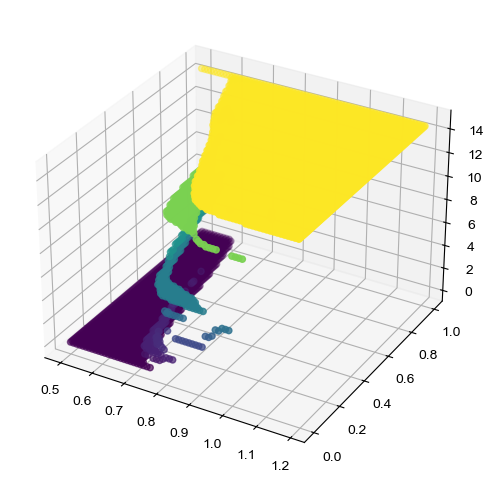

In [11]:
fig, axes = plt.subplots(1, 1,figsize = (18, 6), subplot_kw=dict(projection='3d'))
x, y = np.meshgrid(th_as, th_bs)
x, y = x.T, y.T
axes.scatter(x, y, np.array(grades_all), c = np.array(grades_all), cmap = 'viridis')

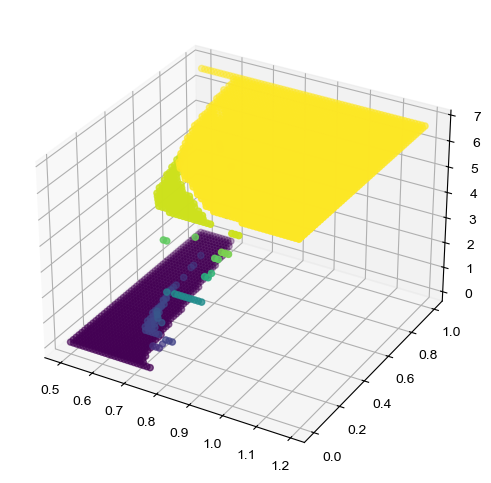

In [15]:

def compute_pareto_front(df):
    """
    计算 Pareto 前沿。

    参数:
    - df (pd.DataFrame): 包含调优结果的 DataFrame。

    返回:
    - pd.DataFrame: 仅包含 Pareto 前沿点的 DataFrame。
    """
    # 按回收率降序排序，如果回收率相同，则按抛废率降序排序
    df_sorted = df.sort_values(['回收率', '抛废率'], ascending=[False, False]).reset_index(drop=True)
    pareto_front = []
    current_max_scrap = -np.inf

    for _, row in df_sorted.iterrows():
        if row['抛废率'] > current_max_scrap:
            pareto_front.append(row)
            current_max_scrap = row['抛废率']

    return pd.DataFrame(pareto_front)

In [16]:
compute_pareto_front(grade2th_1p4)

,threshold_A,threshold_B,抛废率,回收率,品位阈值,铅富集比,锌富集比,准确率,精确率,召回率,准确率_重量,精确率_重量,召回率_重量,准确率_品位,精确率_品位,召回率_品位,grade_th
0,0.72,0.03,0.193816,0.975596,0.016435,1.213239,1.208017,0.504950,0.333333,0.980198,0.435665,0.301607,0.994675,0.933294,0.935533,0.995123,1.4
1,0.71,0.07,0.199629,0.974627,0.016435,1.221243,1.215302,0.512376,0.336735,0.980198,0.441477,0.303797,0.994675,0.934649,0.936847,0.995123,1.4
2,0.71,0.08,0.203744,0.974288,0.016435,1.227262,1.221066,0.517327,0.339041,0.980198,0.445593,0.305367,0.994675,0.935007,0.937194,0.995123,1.4
3,0.73,0.02,0.217737,0.974048,0.016445,1.249775,1.242008,0.527228,0.343750,0.980198,0.459586,0.310829,0.994675,0.935111,0.937296,0.995123,1.4
6,0.72,0.05,0.224704,0.972411,0.016435,1.258964,1.251011,0.539604,0.349823,0.980198,0.466553,0.313623,0.994675,0.937188,0.939319,0.995123,1.4
8,0.72,0.06,0.241236,0.970971,0.016445,1.284281,1.276516,0.554455,0.357401,0.980198,0.483085,0.320456,0.994675,0.938748,0.940844,0.995123,1.4
9,0.72,0.07,0.242315,0.970954,0.016445,1.286101,1.278301,0.556931,0.358696,0.980198,0.484163,0.320912,0.994675,0.938782,0.940879,0.995123,1.4
11,0.73,0.04,0.251790,0.969859,0.016445,1.301695,1.292497,0.566832,0.363971,0.980198,0.493639,0.324976,0.994675,0.939656,0.941735,0.995123,1.4
12,0.74,0.02,0.258260,0.969817,0.016445,1.313561,1.303327,0.571782,0.366667,0.980198,0.500108,0.327811,0.994675,0.939560,0.941641,0.995123,1.4
14,0.75,0.01,0.277969,0.969227,0.016445,1.348496,1.338158,0.584158,0.373585,0.980198,0.519818,0.336759,0.994675,0.938910,0.941004,0.995123,1.4


In [14]:
grade2th_1p4

,threshold_A,threshold_B,抛废率,回收率,品位阈值,铅富集比,锌富集比,准确率,精确率,召回率,准确率_重量,精确率_重量,召回率_重量,准确率_品位,精确率_品位,召回率_品位,grade_th
93672,0.67,0.45,0.241753,0.950542,0.025150,1.260351,1.248981,0.532178,0.338235,0.910891,0.453320,0.300706,0.932736,0.920290,0.941114,0.973118,1.4
93760,0.68,0.32,0.202079,0.961041,0.025150,1.209473,1.200975,0.500000,0.325260,0.930693,0.428206,0.294878,0.962518,0.922452,0.938342,0.978937,1.4
93761,0.68,0.33,0.207955,0.960621,0.025150,1.217709,1.209497,0.507426,0.328671,0.930693,0.434082,0.297066,0.962518,0.922916,0.938802,0.978937,1.4
93762,0.68,0.34,0.216952,0.959740,0.025150,1.231000,1.221975,0.517327,0.333333,0.930693,0.443079,0.300479,0.962518,0.924007,0.939885,0.978937,1.4
93763,0.68,0.35,0.227237,0.958297,0.025150,1.245749,1.236214,0.532178,0.340580,0.930693,0.453364,0.304478,0.962518,0.926251,0.942119,0.978937,1.4
93764,0.68,0.36,0.238863,0.950383,0.031015,1.254682,1.244491,0.532178,0.338235,0.910891,0.452688,0.301048,0.937356,0.919839,0.942106,0.971430,1.4
93852,0.69,0.23,0.202021,0.967340,0.020590,1.215161,1.210234,0.509901,0.332180,0.950495,0.435397,0.299399,0.977344,0.929506,0.938893,0.986590,1.4
93853,0.69,0.24,0.211796,0.962283,0.025150,1.227541,1.216272,0.517327,0.334507,0.940594,0.440552,0.300181,0.967895,0.925845,0.939313,0.981778,1.4
93854,0.69,0.25,0.218987,0.960805,0.025150,1.236797,1.225684,0.524752,0.338078,0.940594,0.447743,0.302945,0.967895,0.927111,0.940567,0.981778,1.4
93855,0.69,0.26,0.231953,0.955474,0.031025,1.250832,1.239367,0.532178,0.340580,0.930693,0.456816,0.305525,0.959934,0.922195,0.940700,0.975843,1.4


No such ratio threshold


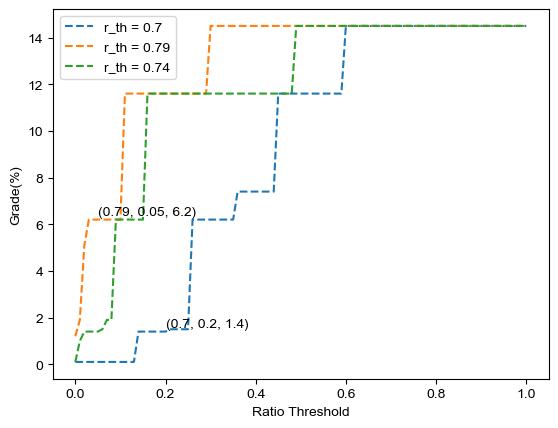

In [10]:
step_B = 0.01

th_B = np.arange(0, 1.01, step_B)
r_ths = [0.7, 0.79, 0.74]
ratio_ths = [0.2, 0.05]

for i, r_th in enumerate(r_ths):
    th_index = round((r_th - 0.5)/0.01)
    
    plt.plot(th_B, grades_all[th_index], label = f'r_th = {r_th}', linestyle = '--')

    try:
        ratio_index = round((ratio_ths[i] - 0)/step_B)
        grade_th = grades_all[th_index][ratio_index]
        # print(grade_th)
        plt.text(ratio_ths[i], grade_th + 0.2, f'{r_th, ratio_ths[i], round(grade_th, 1)}')
    except:
        print('No such ratio threshold')

plt.xlabel('Ratio Threshold')
plt.ylabel('Grade(%)')
plt.legend()

In [236]:
grade_ths

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9])

In [38]:
keys_dict = {
'sr':[0.2, 1],
'rr':[0.95, 1],
'recall': [0.6, 1],
'en': [1.5, 2.5],
'accuracy': [0.6, 1],
}

keys_name_dict = {
'sr': '抛废率',
'rr': '回收率',
'accuracy': '准确率',
'precision': '精确度',
'recall': '召回率',
'en': '铅锌富集比'
}

def plot_separate(res_all, keys = ['抛废率', '回收率', '准确率'], alg_i = 0):

    '''
    res_all: all results for different datasets
    alg_i: 0-low; 1-high energy image; 2; r_method
    '''

    th_a = np.arange(0, 256, 1) #res_all[1][0]['threshold_A']
    th_b = np.arange(0, 1.01, 0.05); #res_all[1][0]['threshold_B']
    x, y = np.meshgrid(th_a, th_b) 
    xlim = [0, 160]

    if alg_i == 2: # 2 is R method
        th_a = np.arange(0.5, 1.2, 0.01)
        x, y = np.meshgrid(th_a, th_b) 
        xlim = [0.5, 1.2]

    ranges = [keys_dict[key] for key in keys]

    all_adding = []; 
    for j, key in enumerate(keys):
        key = keys_name_dict[key]
        adding_i = 0

        for i in range(len(res_all)):

            if key == '铅锌富集比':
                rate = ((res_all[i][alg_i]['铅富集比'].values + res_all[i][alg_i]['锌富集比'].values)/2).reshape(len(th_a), len(th_b)).T
            else:
                rate = res_all[i][alg_i][key].values.reshape(len(th_a), len(th_b)).T
            # hb = plt.hexbin(th_a, th_b, C=accuracy, gridsize=20, cmap='viridis')

            rate_i = ((rate > ranges[j][0]) & (rate < ranges[j][1])).astype('int')
            adding_i += rate_i

        all_adding.append(adding_i)

    # 创建图形和主坐标轴
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('r值阈值')
    ax.set_ylabel('比例阈值')
    ax.set_xlim(xlim[0], xlim[1])
    ax.text(1.125*xlim[0], 0.6, f'{keys_name_dict['sr']}', color='white', ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
    ax.text(0.625*xlim[1], 0.2, f'{keys_name_dict['rr']}', color='white', ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    divider = make_axes_locatable(ax)

    for j in range(len(keys)):

        # 绘制第一个 contourf (sr_all)
        if j == 2:
            cmap = 'coolwarm'; level_max = 5.5; alpha = 0.8
        else:
            cmap = 'viridis'; level_max = 5.5; alpha = 0.5
        cf1 = ax.contourf(x, y, all_adding[j], levels=np.arange(1, level_max, 0.5), cmap=cmap, alpha=alpha)

        # 创建第一个 colorbar 的坐标轴
        cax1 = divider.append_axes("right", size="5%", pad=0.5)
        cbar1 = plt.colorbar(cf1, cax=cax1)
        cbar1.set_label(keys_name_dict[keys[j]])

    plt.tight_layout()
    plt.show()
    
    return all_adding

def plot_adding(metrics_all, title = '', xlim = [0, 160], plot = True, alg_i = 0):
    '''
    '''
    th_a = np.arange(0, 256, 1) #res_all[1][0]['threshold_A']
    th_b = np.arange(0, 1.01, 0.05); #res_all[1][0]['threshold_B']
    x, y = np.meshgrid(th_a, th_b) 

    if alg_i == 2: # 2 is R method
        th_a = np.arange(0.5, 1.2, 0.01)
        x, y = np.meshgrid(th_a, th_b) 

    Z = sum(metrics_all) #rr_all + sr_all

    max_val = np.max(Z)
    max_pos = np.unravel_index(np.argmax(Z), Z.shape)

    best_paras_obtained = x[max_pos], y[max_pos]
    
    if plot:
        plt.figure(figsize = (9, 6))
    
        plt.contourf(x, y, Z, levels=10, cmap='viridis', alpha = 0.5)
        plt.xlim(xlim[0], xlim[1])
        # 标注最大值
        # print(x[max_pos], y[max_pos])
        plt.text(0.75*xlim[1], 0.2, f'Max thresholds: {'%.2f'%x[max_pos], y[max_pos]}', 
                color='white', ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

        # plt.contourf(x, y, rr, levels=np.arange(0.9, 1.0, 0.01), cmap = 'viridis', alpha = 0.8)
        plt.colorbar()
        plt.xlabel('r值阈值')
        plt.ylabel('比例阈值')
        plt.title(title)
        plt.show()

    return best_paras_obtained, Z

In [113]:
keys = ['accuracy', 'recall']
tuning_result = all_tuning[0]
res1 = tuning_result[keys_name_dict[keys[0]]]
res2 = tuning_result[keys_name_dict[keys[1]]]

th_A = tuning_result['threshold_A']
th_B = tuning_result['threshold_B']
res = res1 + res2
max_pos = np.unravel_index(np.argmax(res), res.shape)

best_paras_obtained = th_A.loc[max_pos], th_B.loc[max_pos]
print(best_paras_obtained, res1.loc[max_pos], res2.loc[max_pos])

(0.8400000000000003, 0.0) 0.7326732673267327 0.8709677419354839


In [114]:
res.max()

1.6036410092622164

In [ ]:
def th2grade(tuning_result, input_name, keys, plot = False):

    th_A = tuning_result['threshold_A']
    th_B = tuning_result['threshold_B']

    # ranges = [keys_dict[key] for key in keys]
    vmaxs = [1, 1, 2]

    res1 = tuning_result[keys_name_dict[keys[0]]]
    res2 = tuning_result[keys_name_dict[keys[1]]]

    res = res1 + res2
    max_pos = np.unravel_index(np.argmax(res), res.shape)

    best_paras_obtained = th_A.loc[max_pos], th_B.loc[max_pos]
    print(f"{best_paras_obtained[0]:.2f}, {best_paras_obtained[1]:.2f}, {res1.loc[max_pos]:.4f}, {res2.loc[max_pos]:.4f}")

In [127]:
def plot_3d_metrics(tuning_result, input_name, keys, plot = False):
    th_A = tuning_result['threshold_A']
    th_B = tuning_result['threshold_B']
    pb_en = tuning_result['铅富集比']
    zn_en = tuning_result['锌富集比']

    # ranges = [keys_dict[key] for key in keys]
    vmaxs = [1, 1, 2]

    res1 = tuning_result[keys_name_dict[keys[0]]]
    res2 = tuning_result[keys_name_dict[keys[1]]]

    res = res1 + res2
    max_pos = np.unravel_index(np.argmax(res), res.shape)

    best_paras_obtained = th_A.loc[max_pos], th_B.loc[max_pos]
    print(f"{best_paras_obtained[0]:.2f}, {best_paras_obtained[1]:.2f}, {res1.loc[max_pos]:.4f}, {res2.loc[max_pos]:.4f}")

    if plot:
        fig1, axes1 = plt.subplots(1, 3,figsize = (18, 6), subplot_kw=dict(projection='3d'))
        fig2, axes2 = plt.subplots(1, 3,figsize = (18, 4))

        for i, key in enumerate(keys):
            axes1[i].set_xlabel('r值阈值')
            axes1[i].set_ylabel('比例阈值')
            axes1[i].set_zlabel(key)
            axes2[i].set_xlabel('r值阈值')
            axes2[i].set_ylabel('比例阈值')

            if i == 2:
                axes1[i].scatter(th_A, th_B, res, c=res, cmap='viridis', vmin=0, vmax=vmaxs[i])
                hb = axes2[i].hexbin(th_A, th_B, C=res, gridsize=20, cmap='viridis', vmin=0, vmax=vmaxs[i])

            else: 
                key = keys_name_dict[key]
                axes1[i].scatter(th_A, th_B, tuning_result[key], c=tuning_result[key], cmap='viridis', vmin=0, vmax=vmaxs[i])
                hb = axes2[i].hexbin(th_A, th_B, C=tuning_result[key], gridsize=20, cmap='viridis', vmin=0, vmax=vmaxs[i])
                
            fig2.colorbar(hb, ax=axes2[i], label=key)

    return best_paras_obtained


    # from mpl_toolkits.mplot3d import Axes3D
    # plt.close()
    # 创建3D图
    # for i in range(len(axes)):
    # ax = fig.add_subplot(131, projection='3d')

In [122]:
keys_dict = {
'sr':[0.2, 1],
'rr':[0.95, 1],
'recall': [0.5, 1],
'en': [1.5, 2.5],
'accuracy':[0.5, 1]
}

keys_name_dict = {
'sr': '抛废率',
'rr': '回收率',
'accuracy': '准确率',
'precision': '精确度',
'recall': '召回率',
'accuracy_weight': '准确率_重量',
'accuracy_grade':'准确率_品位',
'en': '铅锌富集比'
}

(0.8400000000000003, 0.0) 0.7326732673267327 0.8709677419354839


(0.8400000000000003, 0.0)

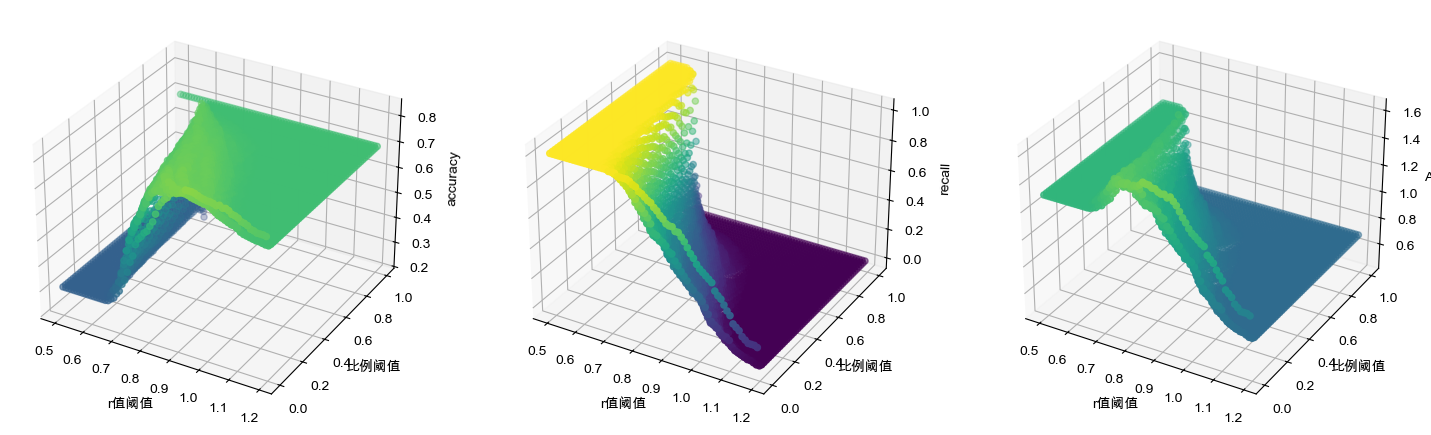

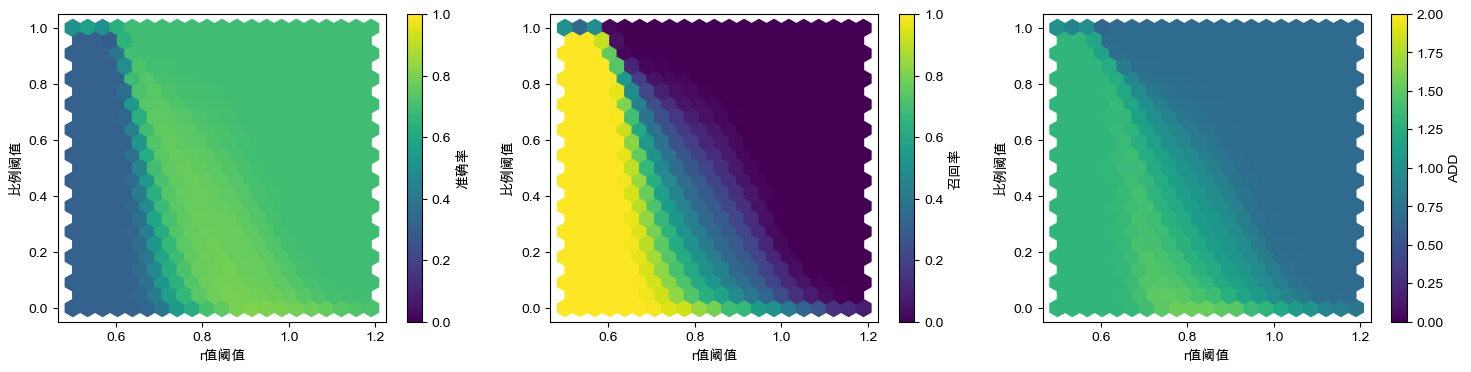

In [123]:
plot_3d_metrics(all_tuning[0], 'test', keys = ['accuracy', 'recall', 'ADD'], plot = True)

In [128]:
best_params = []
for i in range(len(all_tuning)):
    print(grade_ths[i], end = ' ')
    best_i = plot_3d_metrics(all_tuning[i], 'test', keys = ['accuracy', 'recall', 'ADD'])
    best_params.append(best_i)

1.0 0.84, 0.00, 0.7327, 0.8710
1.25 0.86, 0.00, 0.7673, 0.8739
1.5 0.86, 0.00, 0.7574, 0.8990
1.75 0.88, 0.00, 0.7847, 0.8966
2.0 0.93, 0.00, 0.8243, 0.8642
2.25 0.93, 0.00, 0.8243, 0.8734
2.5 0.93, 0.00, 0.8218, 0.8919
2.75 0.93, 0.00, 0.8218, 0.9028
3.0 0.93, 0.00, 0.8243, 0.9538
3.25 0.93, 0.00, 0.8144, 0.9508
3.5 0.93, 0.00, 0.8144, 0.9661
3.75 0.93, 0.00, 0.8119, 0.9655
4.0 0.93, 0.00, 0.8094, 0.9649
4.25 0.93, 0.00, 0.8045, 1.0000
4.5 0.94, 0.00, 0.8069, 1.0000
4.75 0.94, 0.00, 0.8069, 1.0000
5.0 0.94, 0.00, 0.8045, 1.0000
5.25 0.86, 0.06, 0.8589, 0.9535
5.5 0.86, 0.06, 0.8564, 0.9524
5.75 0.86, 0.06, 0.8540, 0.9512
6.0 0.86, 0.06, 0.8490, 0.9487
6.25 0.86, 0.06, 0.8490, 0.9730
6.5 0.86, 0.06, 0.8490, 0.9730
6.75 0.86, 0.06, 0.8465, 0.9722


In [130]:
best_params = np.array(best_params)

Text(0.5, 0, '品位阈值')

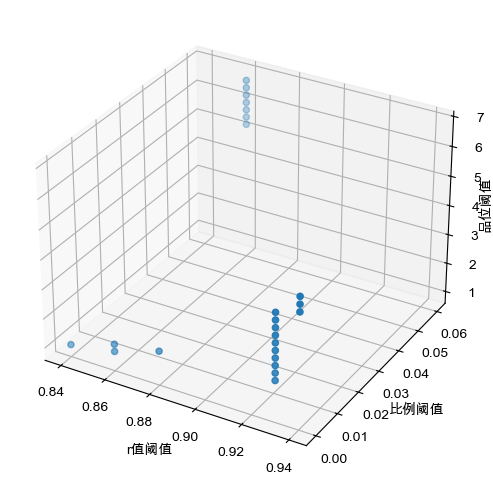

In [131]:
ax = plt.figure(figsize = (6, 8)).add_subplot(projection='3d')
ax.scatter(best_params[:, 0], best_params[:, 1], grade_ths)
ax.set_xlabel('r值阈值')
ax.set_ylabel('比例阈值')
ax.set_zlabel('品位阈值', rotation=90, labelpad=-5)

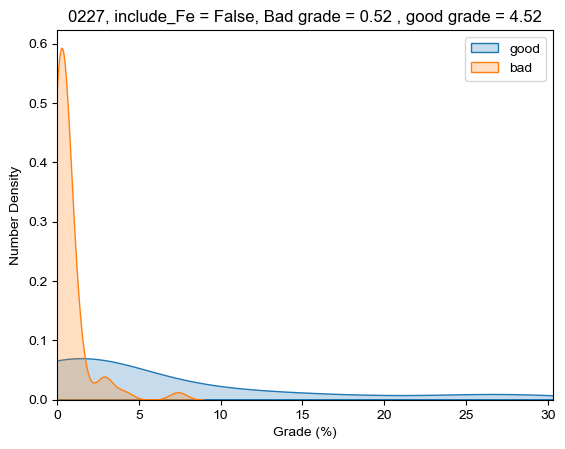

In [ ]:
include_fe = False
for i in range(4, 5):
    R_0219 = RMethodClassifier(pixels=input_all[i][0], truth=input_all[i][1], I0_low=195, I0_high=196, input= 'pixels', method= 'a', const= [5, 20], include_Fe = False)

    index = ((R_0219.R_pixels.apply(np.mean) > 0.70) == True)

    if include_fe:
        fe_good = R_0219.fe_grade[index]
        fe_bad = R_0219.fe_grade[~index]
    else:
        fe_good = 0
        fe_bad = 0

    pb_zn_good = (R_0219.pb_grade[index] + R_0219.zn_grade[index] + fe_good)*100
    good_grade = np.average(R_0219.pb_grade[index] + R_0219.zn_grade[index] + fe_good, weights = R_0219.weight[index])*100
    pb_zn_good_sorted = np.sort(pb_zn_good)

    pb_zn_bad = (R_0219.pb_grade[~index] + R_0219.zn_grade[~index] + fe_bad)*100
    bad_grade = np.average(R_0219.pb_grade[~index] + R_0219.zn_grade[~index] + fe_bad, weights = R_0219.weight[~index])*100
    pb_zn_bad_sorted = np.sort(pb_zn_bad)

    plt.figure()
    plt.xlim(0, pb_zn_good.max())
    sns.kdeplot(pb_zn_good_sorted, label='good', fill=True)
    sns.kdeplot(pb_zn_bad_sorted, label='bad', fill=True)
    plt.legend()
    plt.ylabel('Number Density')
    plt.xlabel('Grade (%)')
    plt.title('%s, include_Fe = %s, Bad grade = %.2f , good grade = %.2f' % (input_names[i], include_fe, bad_grade, good_grade))

交点: [-0.9419907781593121, 1.7094029391627708]


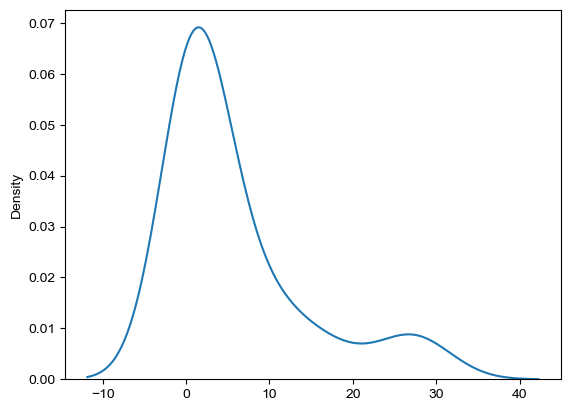

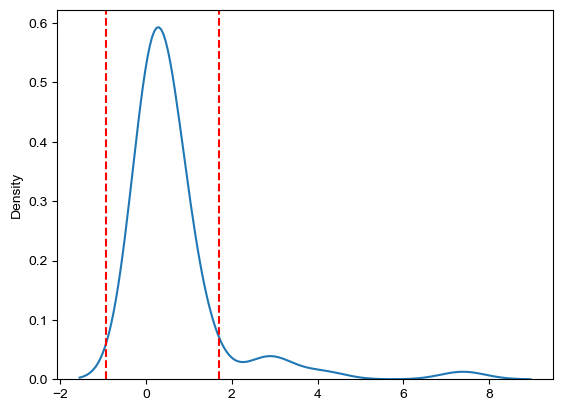

In [114]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

# 生成KDE曲线
kde_good = sns.kdeplot(pb_zn_good_sorted, label='good', fill=False)

# 获取KDE曲线的数据
x_good, y_good = kde_good.get_lines()[0].get_data()
plt.figure()
kde_bad = sns.kdeplot(pb_zn_bad_sorted, label='bad', fill=False)
x_bad, y_bad = kde_bad.get_lines()[0].get_data()

# 对KDE曲线进行插值
f_good = interp1d(x_good, y_good, kind='linear', fill_value="extrapolate")
f_bad = interp1d(x_bad, y_bad, kind='linear', fill_value="extrapolate")

# 定义差值函数
def difference(x):
    return f_good(x) - f_bad(x)

# 找到交点
intersection_points = []
for i in range(len(x_good) - 1):
    if difference(x_good[i]) * difference(x_good[i + 1]) < 0:
        intersection = brentq(difference, x_good[i], x_good[i + 1])
        intersection_points.append(intersection)

# 打印交点
print("交点:", intersection_points)

# 在图中标记交点
for point in intersection_points:
    plt.axvline(x=point, color='red', linestyle='--', label='交点' if point == intersection_points[0] else "")

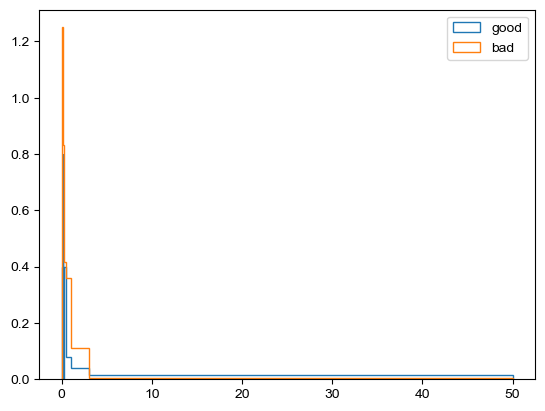

In [44]:
plt.hist(pb_zn_good_sorted, label = 'good', histtype='step', density=True, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 50]) 
plt.hist(pb_zn_bad_sorted, label = 'bad', histtype='step', density=True, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 50])
plt.legend()

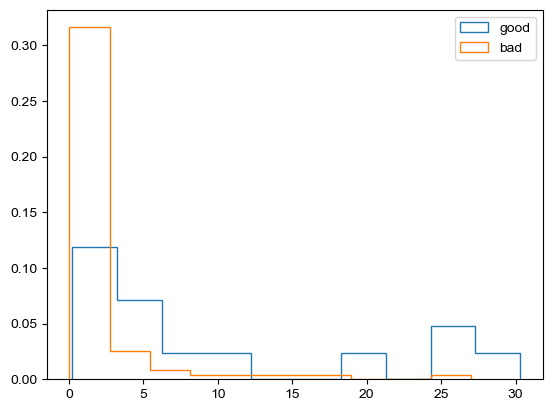

In [80]:
plt.hist(pb_zn_good_sorted, label = 'good', histtype='step', density = True) 
plt.hist(pb_zn_bad_sorted, label = 'bad', histtype='step', density = True)
plt.legend()